# Train model with dense neural network approach

## Initialize dataset for model training and evaluation

In [1]:
# control if using sampled or original data
import joblib
from config import TRAIN_TEST_SPLIT_ELECTRIC_FILE, TRAIN_TEST_SPLIT_ELECTRIC_FILE_SAMPLED

is_sampled = False

In [2]:
# load data
if is_sampled:
    X_train, X_test, y_train, y_test = joblib.load(TRAIN_TEST_SPLIT_ELECTRIC_FILE_SAMPLED)
else:
    X_train, X_test, y_train, y_test = joblib.load(TRAIN_TEST_SPLIT_ELECTRIC_FILE)

In [3]:
# temporary reduce the size of the dataset for testing
# X_train = X_train[:10000]
# y_train = y_train[:10000]
# X_test = X_test[:1000]
# y_test = y_test[:1000]

In [4]:
# example prints to validate correct output
X_train.head(2)

,member_state_AT,member_state_BE,member_state_BG,member_state_CY,member_state_CZ,member_state_DE,member_state_DK,member_state_EE,member_state_ES,member_state_FI,...,commercial_name_iX3,commercial_name_other,category_of_vehicle_M1,category_of_vehicle_M1,category_of_vehicle_M1G,category_of_vehicle_N1,mass_vehicle,engine_power,year,electric_range
2349347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.435929,0.916329,1.023808,0.436143
1270572,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.775093,0.065619,-0.229645,0.146002


In [5]:
X_train.shape

(2661120, 298)

In [6]:
X_test.shape

(1140481, 298)

## Train Dense Neural Network model with tensorflow keras

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from config import ELECTRIC_NN_CKPT_MODEL_FILE, ELECTRIC_NN_MODEL_FILE
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [8]:
# Instantiate the model
inputs = Input(shape=(X_train.shape[1],))

# Dense with relu as activation function for regression problem -> Multiple layers but sequentially reducing number of units
# BatchNormalization: Normalizes activations to stabilize training.
# Dropout: Prevents overfitting by randomly disabling neurons.

# --- Model for entire dataset
# -> Model was overfitting with this configuration

x = Dense(64, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(32, activation='relu')(x)
# ---

# --- Model for small sample
# x = Dense(128, activation='relu')(inputs)
# x = BatchNormalization()(x)
# x = Dropout(0.3)(x)

# x = Dense(64, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.2)(x)

# x = Dense(32, activation='relu')(x)
# ---
outputs = Dense(1)(x)  # Regression -> No activation function

# Create model
model = Model(inputs=inputs, outputs=outputs)

In [9]:
# display model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 298)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        19,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,921 (101.25 KB)

 Trainable params: 25,665 (100.25 KB)

 Non-trainable params: 256 (1.00 KB)

In [10]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])
# loss: MSE (Mean Squared Error)
# metric: MAE (Mean Absolute Error)

In [11]:
# Define Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',  # Stop if validation loss stops improving
    patience=10,         # Wait n epochs before stopping
    restore_best_weights=True  # Load best weights after stopping
)

model_checkpoint = ModelCheckpoint(
    ELECTRIC_NN_CKPT_MODEL_FILE,  # File to save the best model
    monitor='val_loss',  # Save model when val_loss improves
    save_best_only=True  # Only save the best version
)



In [12]:
# Train the model
model_history = model.fit(
    X_train, y_train,
    epochs=100,  # 50
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
66528/66528 ━━━━━━━━━━━━━━━━━━━━ 176s 3ms/step - loss: 226.0708 - mae: 7.4301 - val_loss: 45.1231 - val_mae: 3.1805
Epoch 2/100
66528/66528 ━━━━━━━━━━━━━━━━━━━━ 202s 3ms/step - loss: 49.5320 - mae: 3.9836 - val_loss: 2104.9717 - val_mae: 3.4304
Epoch 3/100
66528/66528 ━━━━━━━━━━━━━━━━━━━━ 212s 3ms/step - loss: 44.0112 - mae: 3.7306 - val_loss: 1624.8397 - val_mae: 3.1197
Epoch 4/100
66528/66528 ━━━━━━━━━━━━━━━━━━━━ 187s 3ms/step - loss: 41.8386 - mae: 3.6355 - val_loss: 5745.1230 - val_mae: 3.6075
Epoch 5/100
66528/66528 ━━━━━━━━━━━━━━━━━━━━ 191s 3ms/step - loss: 40.3972 - mae: 3.5231 - val_loss: 438.5863 - val_mae: 3.8796
Epoch 6/100
66528/66528 ━━━━━━━━━━━━━━━━━━━━ 179s 3ms/step - loss: 40.3169 - mae: 3.4866 - val_loss: 11619.5684 - val_mae: 3.4422
Epoch 7/100
66528/66528 ━━━━━━━━━━━━━━━━━━━━ 169s 3ms/step - loss: 38.2334 - mae: 3.4421 - val_loss: 3122.6167 - val_mae: 3.0568
Epoch 8/100
66528/66528 ━━━━━━━━━━━━━━━━━━━━ 159s 2ms/step - loss: 39.3395 - mae: 3.4125 - val_los

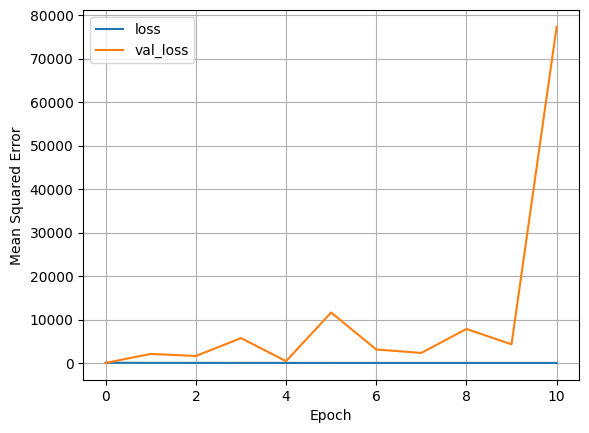

'\nInterpretation:\nIdeal Case (Good Fit)\n- loss and val_loss both decrease smoothly.\n- They converge to a stable value without diverging.\n- Small gap between loss and val_loss.\n\nUnderfitting (Not Learning Well)\n- Both loss and val_loss remain high.\n- They don\'t decrease much, meaning the model is too simple.\n\nOverfitting (Memorizing Training Data)\n- loss keeps decreasing, but val_loss starts increasing after some epochs.\n- The model performs well on training data but poorly on validation data."\n'

In [27]:
# display loss evolution

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    # plt.ylim([0,30000])
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(model_history)

"""
Interpretation:
Ideal Case (Good Fit)
- loss and val_loss both decrease smoothly.
- They converge to a stable value without diverging.
- Small gap between loss and val_loss.

Underfitting (Not Learning Well)
- Both loss and val_loss remain high.
- They don't decrease much, meaning the model is too simple.

Overfitting (Memorizing Training Data)
- loss keeps decreasing, but val_loss starts increasing after some epochs.
- The model performs well on training data but poorly on validation data."
"""

In [14]:
# Store model
joblib.dump(model, ELECTRIC_NN_MODEL_FILE)

['files/output/models/electric-nn_model.keras']

## Evaluate results of DNN Model

In [15]:
# Evaluate preditions
# test_results = model.evaluate(X_test, y_test, verbose=0)
loss, mae = model.evaluate(X_test, y_test, verbose=2)
print(f'Model, error (mae): {mae:5.2f}')
print(f'Model, loss (mse): {loss:5.2f}')

35641/35641 - 41s - 1ms/step - loss: 42.8103 - mae: 3.1607
Model, error (mae):  3.16
Model, loss (mse): 42.81


In [16]:
# Predict against test data
y_pred = model.predict(X_test).flatten()


35641/35641 ━━━━━━━━━━━━━━━━━━━━ 33s 927us/step


In [17]:
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
import numpy as np
# calculate metrics

# R-Squared
r2 = r2_score(y_test, y_pred)
print("R-Squared: ",r2)

# Adjusted R-Squared
n = len(y_test)  # Number of samples
p = X_test.shape[1]  # Number of features
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print("Adjusted R-Squared: ",adjusted_r2)

# MSE
mean_squared_error_reg = mean_squared_error(y_true=y_test, y_pred=y_pred)
print("MSE: ",mean_squared_error_reg)

# RMSE
root_mean_squared_error_reg = root_mean_squared_error(y_true=y_test, y_pred=y_pred)
print("RMSE: ",root_mean_squared_error_reg)

mean_y_test = np.mean(y_test)
mean_y_pred = np.mean(y_pred)

# check if RMSE within treshold
desired_threshold = 0.05 * 100

rmse_test_perc = (root_mean_squared_error_reg * 100) / mean_y_test

print(f"RMSE error percentage compared to mean: {rmse_test_perc:.2f}% within treshhold (max {desired_threshold:.2f}%): ", rmse_test_perc < desired_threshold)


R-Squared:  0.928676402332705
Adjusted R-Squared:  0.9286577610700777
MSE:  42.81025088211764
RMSE:  6.542954293139884
RMSE error percentage compared to mean: 3.89% within treshhold (max 5.00%):  True


### Compare predicted vs. actual values

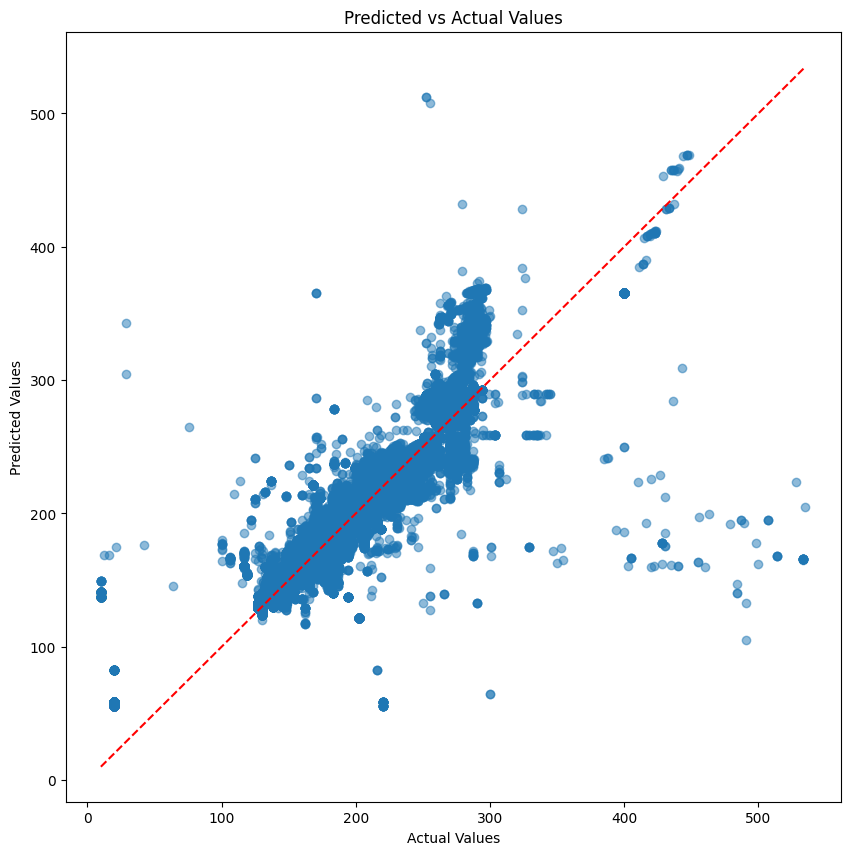

In [18]:
# Scatter Plot
# Plot predicted vs. actual values
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.show()

### Analyze residuals and their distribution

In [19]:
residuals = y_test - y_pred

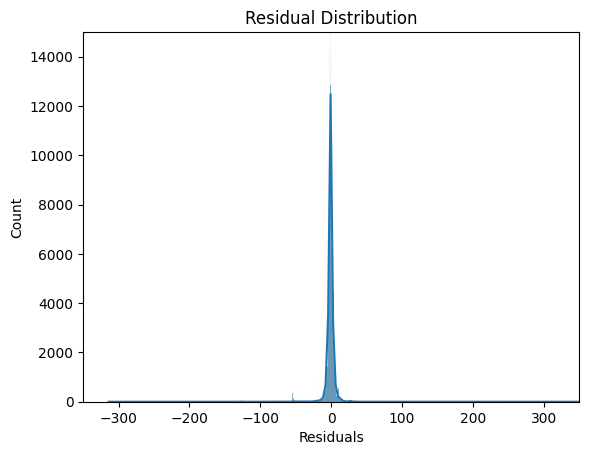

In [22]:
sns.histplot(residuals, kde=True)
plt.xlabel("Residuals")
plt.title("Residual Distribution")
plt.ylim([0, 15000])
plt.xlim([-350, 350])
plt.show()